![UTFSM](https://github.com/tclaudioe/Scientific-Computing-V3/blob/main/images/Departamento%20de%20Inform%C3%A1tica%20cromatica%20negra%404x-8.png?raw=true)
# INF-285 - Computación Científica
## Least Squares
## Version: 1.41
## [Acknowledgements](#acknowledgements)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tclaudioe/Scientific-Computing-V3/blob/main/06_Least_Squares.ipynb)

<div id='toc' />

## Table of Contents
* [Introduction](#intro)
* [Overdetermined Linear System of Equations](#over)
    * [Initial Example](#initialExample)
* [QR Factorization](#qr)
    * [Do we really have _truly_ unitary vectors?](#DoWeReallyHaveUnitaryVectors)
    * [Examples of QR: Classic vs Modified Gram-Schmidt](#ex)
    * [Using the QR factorization to solve least-square problems](#qrls)
* [Addional examples](#sm)
* [Acknowledgements](#acknowledgements)

In [1]:
##########################
# CoLab requirements
# https://stackoverflow.com/questions/44210656/how-to-check-if-a-module-is-installed-in-python-and-if-not-install-it-within-t
##########################

# https://pypi.org/project/colorama/

import importlib.util
import sys
import subprocess
import os
    
# install_colab_requirements 
libraries = ['numpy', 'scipy', 'matplotlib', 'colorama', 
            'bitstring', 'sympy', 'ipywidgets','pandas']

for library in libraries:
    # Check if the library is already installed
    if importlib.util.find_spec(library) is not None:
        print(f"{library} is already installed.")
    else:
        print(f"{library} is not installed. Installing...")
        # Install the library using pip
        subprocess.check_call([sys.executable, "-m", "pip", "install", library])
        print(f"{library} has been installed.")
# https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab
if os.getenv("COLAB_RELEASE_TAG"):
    print('Installing LaTeX support in CoLab')
    # Adding LaTeX dependencies to CoLab: https://stackoverflow.com/questions/55746749/latex-equations-do-not-render-in-google-colaboratory-when-using-matplotlib
    !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
else:
   print('Running on local environment')

numpy is already installed.
scipy is already installed.
matplotlib is already installed.
colorama is already installed.
bitstring is already installed.
sympy is already installed.
ipywidgets is already installed.
pandas is already installed.
Running on local environment


In [1]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import scipy.linalg as spla # type: ignore
%matplotlib inline
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets
from sklearn import datasets # type: ignore
import ipywidgets as widgets # type: ignore
import matplotlib as mpl # type: ignore
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
M=8
from ipywidgets import interact # type: ignore
# https://pypi.org/project/colorama/
# %conda install -c anaconda colorama
# or
# !pip install colorama
from colorama import Fore, Back, Style # type: ignore
# https://pypi.org/project/colorama/
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL
textBold = lambda x: Style.BRIGHT+x+Style.RESET_ALL
textBoldH = lambda x: Style.BRIGHT+Back.YELLOW+x+Style.RESET_ALL

textQRClassic = lambda x: Style.BRIGHT+Fore.RED+x+Style.RESET_ALL
textQRModified = lambda x: Style.BRIGHT+Fore.BLUE+x+Style.RESET_ALL
textAnswer = lambda x: Style.BRIGHT+Back.YELLOW+Fore.WHITE+x+Style.RESET_ALL

<div id='intro' />

## Introduction
[Back to TOC](#toc)

We have learned about **square** linear system of equations. 
However, can we solve a **non-square/rectangular** linear system of equations? i.e. when we have more equations than unknowns!
Well, a traditional alternative is to find a least squares approximation!

<div id='over' />

# Overdetermined Linear Systems of Equations
[Back to TOC](#toc)

There are cases where the number of equations is greater than the number of unknowns. 
Many times, these systems don't have an exact solution (they are inconsistent system).
In this case, we find a numerical approximation that minimizes an error.
In particular, we use as error the vector 2-norm for the residual vector.
We define the **minimal** residual vector as:
$$
\begin{align*}
    \mathbf{r} &= \mathbf{b}-A\,\overline{\mathbf{x}}.
\end{align*}
$$
We know the following for this **minimal** residual vector:
1. $\mathbf{b}$ corresponds to the vector that **we want** to represent as a **linear combination of the column vectors of the matrix $A$**, i.e. $A\,\mathbf{x}$.
2. Among all the vectors that belong to the column-space of $A$, i.e. $A\,\mathbf{x}$, there is only one vector that minimizes the **distance** between the vector $\mathbf{b}$ and the vectors that belong to the column-space of $A$. This minimizer is denoted as $A\,\overline{\mathbf{x}}$.
3. The minimal distance can be computed as the 2-norm of the difference between $\mathbf{b}$ and $A\,\overline{\mathbf{x}}$. This means that the 2-norm of the residual vector $\mathbf{r} = \mathbf{b}-A\,\overline{\mathbf{x}}$, which is $\|\mathbf{r}\|$ is the minimal distance.
4. Another important condition we can highlight is the **ortogonality** between the residual vector $\mathbf{r}$ and the column-space of $A$, i.e. all the vectors that can be represented as $A\,\mathbf{x}$. 
This induces the following equation $\langle A\,\mathbf{x}, \mathbf{r} \rangle=0$, i.e. the inner product is equal to 0.
Replacing the definition of $\mathbf{r}$, we obtain,
\begin{align*} 
    \left(A\,\mathbf{x}\right)^\top\,\left(\mathbf{b}-A\,\overline{\mathbf{x}}\right)&=0,   && \textrm{Expanding the Transpose operator $^\top$},\\
    \mathbf{x}^\top\, A^\top\,\left(\mathbf{b}-A\,\overline{\mathbf{x}}\right)&=0,          && \textrm{Re-organizing the terms},\\
    \underbrace{\mathbf{x}^\top}_{\displaystyle\textrm{(I)}}\, \underbrace{\left(A^\top\,\mathbf{b}-A^\top\,A\,\overline{\mathbf{x}}\right)}_{\displaystyle\textrm{(II)}}&=0,
\end{align*}
Now, recalling that the residual must be orthogonal to any vector that belong to the column-space of $A$, this implies that the vector $\mathbf{x}$, i.e. $\textrm{(I)}$ can't assure the product will be $0$. Therefore, the term  $\textrm{(II)}$ must be the null-vector.
Thus,
\begin{align*} 
    A^\top\,\mathbf{b}-A^\top\,A\,\overline{\mathbf{x}}&=\mathbf{0}, \\
    A^\top\,A\,\overline{\mathbf{x}}&= A^\top\,\mathbf{b}. \\
\end{align*}

This last equation gives us a new **square** $n\times n$ matrix, which can be solved with any linear system of equations solver.
This linear system of equations is known as the **Normal Equations**.

<div id='initialExample' />

## Initial example:
[Back to TOC](#toc)

In this example we will approximate $m$ points considering a linear relationship between the variables $x$ and $y$.
Consider that we have $m$ data points  $(x_i,y_i)$ for $i\in\{1,2,\dots,m\}$, and we consider the relationshop $y=a_0+a_1\,x$.

**Notice: 
The linear approximation here proposed is the typical example one could use, but you could also use other kind of approximations, for instance $y=a_0+a_1\,x+a_2\,x^2$, and so on. 
It is important to highlight that even though the relation between the _dependent_ variable $y$ and the _independent_ is not linear in this last example, the problem we will be solving with least-square will still be ``linear'' on the unknowns variables $a_0$, $a_1$, and $a_2$, respectively.**

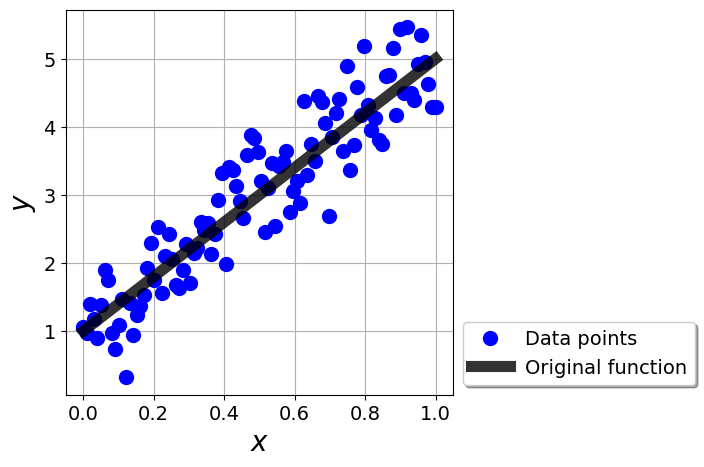

In [2]:
# Number of points to be used
m = 100
# Relationship considered
fv = np.vectorize(lambda x, a0, a1: a0+a1*x)
# "Exact" coefficients considered
a0_exact, a1_exact = 1, 4

# Fixing the 'seed' of the random number generator to obtain reproducible outcomes.
rng = np.random.Generator(np.random.PCG64(seed=0))

# Error:
# Standard deviation for the error
sigma = 5e-1
# Error to be added
e = rng.normal(0, sigma, m)

# Generating data points
x = np.linspace(0,1,m)
y = fv(x,a0_exact,a1_exact)+e
# Challenging question: What if all the xi are the same?
# This means that considering the following definition for x, for instance:
# x = np.linspace(0,1,m)*0+0.5

# Plotting the data
plt.figure(figsize=(5,5))
plt.plot(x,y,'b.',markersize=20, label='Data points')
plt.plot(x,fv(x,a0_exact,a1_exact),'k-',linewidth=8,alpha=0.8, label='Original function')
plt.legend(loc='lower left', ncol=1, fancybox=True, shadow=True, numpoints=1, bbox_to_anchor=(1,0))
plt.grid(True)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

The plot before was build from a _arbitrary_ defined values for $a_0=1$ and $a_1=4$, to then later add some errors $\varepsilon_i$ that follow a Normal distribution $\mathrm{N}(0,\sigma)$, for $\sigma=5\,10^{-1}$.
This way we generated the <span style="color:blue">blue</span> **data points**.
_The purpose of this numerical experiment is to try to recover the **exact** values for $a_0$ and $a_1$ from the **data points** that have error of the $y$ component_.

Now, we will solve the _least-square_ problem with the **Normal Equations**.

In [3]:
# Build the data matrix
A = np.ones((m,2))
A[:,1] = x
# Setting up the right hand side
b = y

# Building and solving the normal equations
# A^T A x_bar = A^T b
x_bar = np.linalg.solve(A.T @ A, A.T @ b)

Now, let's compare the solution found with the exact solution.

In [4]:
print('a0_exact\t:',a0_exact)
print('a0_bar  \t:',x_bar[0],'\n')

print('a1_exact\t:',a1_exact)
print('a1_bar  \t:',x_bar[1])

a0_exact	: 1
a0_bar  	: 1.0041518440034327 

a1_exact	: 4
a1_bar  	: 4.072793005483851


- Are the least-square approximation close to the **exact** values?
- Do they have to be close?
- How does the error changes as we increase $m$ (the number of data points)?
- How does the error changes as we change standard deviation of the error added? Recall that we added an error to perturbate the data points, actually we only perturbated the $y$ values, not the $x$ values.

To answer these questions, keep reading the Jupyter Notebook.

In [5]:
# Computing the quadratic error ||r||_2^2 of the least-square solution
print('Quadratic error of LS solution: ',np.power(np.linalg.norm(b-A @ x_bar),2))
print(textAnswer('This is the actual minimum of the least-square error since this is what does the solution of the Normal Equations.\n'))

# Computing the quadratic error ||r||_2^2 of the "original" parameters
x_original = np.array([a0_exact,a1_exact])
print('Quadratic error of original parameters: ',np.power(np.linalg.norm(b-A @ x_original),2))
print(textAnswer('On the other hand, it may look counterintuitive that the ORIGINAL, i.e. exact, solution get a higher value for the error.'))
print(textAnswer('This is actually correct since the solution that minimizes the LS error is the solution to the Normal Equations and not the EXACT solution.\n'))

# Verifying if the columns of A are orthogonal to the "residual" vector rLS=b-A*x_bar.
print('Inner product of rLS and each column of A: ',A.T @ (b-A @ x_bar))
print(textAnswer('The previous output shows that the residual vector r=b-A @ x_bar is actually orthogonal to the column space of A, i.e. the range of A.\n'))

# Computing the ortogonality condition against the "original" a0_exact y a1_exact, i.e. rOR=b-A*x_no_bar
print('Inner product of rOR and each column of A: ',A.T @ (b-A @ x_original))
print(textAnswer('On the other hand, the residual vector with the exact solution is NOT orthogonal, which is OK since this is not required.'))


Quadratic error of LS solution:  23.097326701044185
This is the actual minimum of the least-square error since this is what does the solution of the Normal Equations.

Quadratic error of original parameters:  23.306792448000188
On the other hand, it may look counterintuitive that the ORIGINAL, i.e. exact, solution get a higher value for the error.
This is actually correct since the solution that minimizes the LS error is the solution to the Normal Equations and not the EXACT solution.

Inner product of rLS and each column of A:  [-2.08721929e-14 -8.10462808e-15]
The previous output shows that the residual vector r=b-A @ x_bar is actually orthogonal to the column space of A, i.e. the range of A.

Inner product of rOR and each column of A:  [4.05483467 2.64628043]
On the other hand, the residual vector with the exact solution is NOT orthogonal, which is OK since this is not required.


Now, just execute the following cell and play with the widget below.

In [6]:
# a0        : Input approximation from widget for a_0 in a_0+a_1*x
# a1        : Input approximation from widget for a_0 in a_0+a_1*x
# m         : Number of data points to be used
# n_samples : Number of "samples" of approximations to be used for plotting on "left" plot
# sigma     : Standard deviation for the error added 
def plot_linear_approximation(a0=1.1,a1=3.5,m=100,n_samples=50, sigma=5e-1):
    
    a0_min = -3
    a0_max = 4
    a1_min = 0
    a1_max = 8
    
    # Fixing the 'seed' of the random number generator to obtain reproducible outcomes.
    rng = np.random.Generator(np.random.PCG64(seed=0))
    
    ############################################################
    # Generating data and solving the least square problem
    ############################################################
    # Relationship considered
    fv = np.vectorize(lambda x, a0, a1: a0+a1*x)
    # "Exact" coefficients considered
    a0_exact, a1_exact = 1, 4

    # Error:
    # Standard deviation for the error
    # sigma = 5e-1
    # Error to be added
    e = rng.normal(0, sigma, m)

    # Generating data points
    x = np.linspace(0,1,m)
    y = fv(x,a0_exact,a1_exact)+e
    
    # Build the data matrix
    A = np.ones((m,2))
    A[:,1] = x
    # Setting up the right hand side
    b = y

    # Building and solving the normal equations
    # A^T A x_bar = A^T b
    x_bar = np.linalg.solve(A.T @ A, A.T @ b)
    
    ############################################################
    # Plotting the data
    ############################################################
    residual = lambda a,b: np.power(np.linalg.norm(y-a*np.ones_like(y)-b*x),2)
    residual_v = np.vectorize(residual)
    random_perturbations = rng.standard_normal((n_samples,2))

    # Showing the comparison between the "original function" and the "least-squared reconstructed approximation".
    # We added in red a "sample" of possible functions.
    # Notice that the colors used follow the description included in the classnotes.
    # This means to consider the following analogy:
    # blue: data points, this correspond to the right-hand-side vector "b".
    # red: this correspond to the sub-space generated by Ax, i.e. the span of the columns of A.
    # violet: This correspond to the least-square solution found.
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    # Data points
    plt.plot(x,y,'b.',markersize=8, label='Data points',alpha=0.8)
    # Non-optimal solutions 
    for i in range(n_samples-1):
        plt.plot(x,fv(x,x_bar[0]+random_perturbations[i,0],x_bar[1]+random_perturbations[i,1]),'-',linewidth=1, alpha=0.2, color='red')
    plt.plot(x,fv(x,x_bar[0]+random_perturbations[-1,0],x_bar[1]+random_perturbations[-1,1]),'r-',linewidth=1,alpha=0.2, label='Non-optimal solutions')

    # Least-Square approximation
    plt.plot(x,fv(x,x_bar[0],x_bar[1]),'-',color='darkviolet',linewidth=4, label=f'Least Square approximation, error: {residual_v(x_bar[0],x_bar[1]):.2f}')
    # Input approximation -> provided by widgets
    plt.plot(x,fv(x,a0,a1),'-',color='red',linewidth=4, label='Input approximation', alpha=0.5)
    # Original functions
    plt.plot(x,fv(x,a0_exact,a1_exact),'k-',linewidth=2,alpha=1, label='Original function')
    
    plt.grid(True)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.xlim([0,1])
    plt.ylim([-1,9])
    plt.legend(loc='best', ncol=1, fancybox=True, shadow=True, numpoints=1, fontsize=8)

    plt.subplot(122)
    # This variable define the "grid" resolution on each dimension, i.e. the number
    # of pixels per dimension.
    grid_resolution = 100
    a0_range = np.linspace(a0_min, a0_max, grid_resolution)
    a1_range = np.linspace(a1_min, a1_max, grid_resolution)
    [a_mat,b_mat] = np.meshgrid(a0_range,a1_range)

    E = residual_v(a_mat,b_mat)

    plt.contourf(a0_range, a1_range, E, levels=20, cmap='Blues')
    
    # Non-optimal solutions 
    for i in range(n_samples-1):
        plt.plot(x_bar[0]+random_perturbations[i,0],x_bar[1]+random_perturbations[i,1],'r.',linewidth=1, alpha=0.5,markersize=2)
    plt.plot(x_bar[0]+random_perturbations[-1,0],x_bar[1]+random_perturbations[-1,1],'r.',linewidth=1,alpha=0.5,markersize=2)
   
    plt.xlim([a0_min,a0_max])
    plt.ylim([a1_min,a1_max])
     
    plt.xlabel(r'$a_0$')
    plt.ylabel(r'$a_1$')
    plt.axis('scaled')
    plt.plot(a0,a1,'r*',markersize=8)
    plt.title(f'Error: {residual_v(a0,a1):.5f}')
    plt.colorbar()

    plt.show()

## Understanding what happends with the **Least-Square** error

The next example shows on the **figure on the left** the following:
1. <span style="color:blue">Data points in blue</span>.
2. <span style="color:red">Non-optimal (sample) approximations in light-red</span>.
3. <span style="color:darkmagenta">The **least-square approximation** in dark magenta</span>.
4. <span style="color:red">Input approximation defined by the widget in red with wide line</span>.
5. Original function in black.

and on the **figure on the right**:
1. In the background shows the plot for the least-square error $E(a_0,a_1)=\sum_{i=1}^m (y_i-a_0-a_1\,x_i)^2=\|\mathbf{y}-a_0\,\mathbf{1}-a_1\,\mathbf{x}\|_2$, where $\mathbf{1}$ is the vector of dimension $m$ of $1$, i.e. $\mathbf{1}=[1,1,\dots,1]^\top$.
2. <span style="color:red">Non-optimal (sample) approximations in light-red</span>.
3. <span style="color:red">Input approximation defined by the widget in red a red star</span>.

In [7]:
interact(plot_linear_approximation,a0=(-1,3,0.1),a1=(2,6,0.1),m=(2,200,1),n_samples=(10,200,10),sigma=(0.0,10.,0.01))

interactive(children=(FloatSlider(value=1.1, description='a0', max=3.0, min=-1.0), FloatSlider(value=3.5, desc…

<function __main__.plot_linear_approximation(a0=1.1, a1=3.5, m=100, n_samples=50, sigma=0.5)>

<div id='qr' />

# QR Factorization

We studied before about the Normal Equations for solving **linear least-square problems**.
This is of high theoretical importance, unfortunately, the Normal Equations may show some numerical issues when dealing with large and ill-conditioned matrices.
To handle this, we will learn about the QR factorization.
The QR factorization will allow us to still find the **least-square** approximation but avoiding computing explicitly the Normal Equations.
But before we can connect the QR factorization with the computation of the **least-square** approximation, we need to learn about the computation of the QR factorization of the matrix $A$ used for the **linear least-square problem**.

## Gram-Schmidt Orthogonalization
[Back to TOC](#toc)

The main purpose for the Gram-Schmidt Orthogonalization is to build an **orthonormal set of vectors** from a **arbitrary** set of vectors such that they **span** the same vector space.
For simplicity, we will consider that the **arbitrary** set of vector are **linearly independent** vectors.
_If they are not linearly independent vectors, the algorithm will **break-down** at some point. 
The good news when it **breaks-down** is that it will give us which are linearly independent vectors!_

For clarity, we will store in a matrix $A$ the set of **linearly independent** vectors, say $A=[\mathbf{a}_1\, ...., \mathbf{a}_n]$, notice that each vectors $\mathbf{a}_i\in\mathbb{R}^m$ and $n \le m$.

We also know the following for the **orthogonal set** we want to build:
$$\begin{align*}
    \mathbf{q}_i^T\,\mathbf{q}_i & = \|\mathbf{q}_i\|_2^2= 1\\
    \mathbf{q}_i^T\,\mathbf{q}_j & = 0, \, \text{ for } i\neq j
\end{align*}$$

Moreover, we have the following relation between the two sets of vectors described:
$$
\underbrace{\begin{bmatrix} 
	\mathbf{a}_{1}, & \mathbf{a}_{2}, & \dots, & \mathbf{a}_{n}
\end{bmatrix}}_{\displaystyle A}
=
\underbrace{\begin{bmatrix} 
	\mathbf{q}_{1}, & \mathbf{q}_{2}, & \dots, & \mathbf{q}_{n}
\end{bmatrix}}_{\displaystyle \widehat{Q}}
\underbrace{\begin{bmatrix}
	r_{1,1} & r_{1,2} & r_{1,3} & \dots  &  r_{1,n} \\
	0      & r_{2,2} & r_{2,3} & \dots  &  r_{2,n} \\
	0      & 0      & r_{3,3} & \dots  &  r_{3,n} \\
	\vdots & \vdots & \ddots & \ddots &  \vdots \\
	0      & \dots  & \dots  &  0     &  r_{nn}
\end{bmatrix}}_{\displaystyle \widehat{R}}.$$
This identity, by means of comparing each column on the **left hand side** with its corresponding column on the **right hand side**, give us:
$$
\begin{align*}
    \mathbf{a}_{1} &= r_{1,1}\,\mathbf{q}_{1},\\
    \mathbf{a}_{2} &= r_{1,2}\,\mathbf{q}_{1}+r_{2,2}\,\mathbf{q}_{2},\\
    \mathbf{a}_{3} &= r_{1,3}\,\mathbf{q}_{1}+r_{2,3}\,\mathbf{q}_{2}+r_{3,3}\,\mathbf{q}_{3},\\
    \vdots          &\qquad \vdots\\
    \mathbf{a}_k   &= r_{1,k}\,\mathbf{q}_{1}+r_{2,k}\,\mathbf{q}_{2}+\dots+r_{k,k}\,\mathbf{q}_{k} &= \displaystyle\sum_{i=1}^{k} r_{i,k}\,\mathbf{q}_{i},\\
    \vdots          &\qquad \vdots\\
    \mathbf{a}_{n} &= r_{1,n}\,\mathbf{q}_{1} + r_{2,n}\,\mathbf{q}_{2}+\dots+r_{n,n}\,\mathbf{q}_{n} &= \displaystyle\sum_{i=1}^{n} r_{i,n}\,\mathbf{q}_{i}.\\
\end{align*}
$$

Then the **classic** Gram-Schmidt orthonormalization finds $\mathbf{q}_i$ and $r_{i,j}$ as follows.

- First equation: $\mathbf{a}_1 = r_{1,1}\,\mathbf{q}_1$, we obtain,
    - $r_{1,1} = \|\mathbf{a}_1\|_2$
    - $\mathbf{q}_1 = \dfrac{\mathbf{a}_1}{r_{11}}$
- Second equation: $\mathbf{a}_2 = r_{1,2}\,\mathbf{q}_1+r_{2,2}\,\mathbf{q}_2$, we obtain,
    - $r_{1,2} = \mathbf{q}_1^\top\,\mathbf{a}_2$
    - $r_{2,2} = \|\mathbf{a}_2-r_{1,2}\,\mathbf{q}_1\|_2$
    - $\mathbf{q}_2 = \dfrac{\mathbf{a}_2-r_{1,2}\,\mathbf{q}_1}{r_{2,2}}$
- **Third equation** (we highlight this equation to explain below the **modified** Gram-Schmidt orthonormalization): $\mathbf{a}_3 = r_{1,3}\,\mathbf{q}_{1}+r_{2,3}\,\mathbf{q}_{2}+r_{3,3}\,\mathbf{q}_{3}$, we obtain,
    - $r_{1,3} = \mathbf{q}_1^\top\,\mathbf{a}_3$
    - $r_{2,3} = \mathbf{q}_2^\top\,\mathbf{a}_3$
    - $r_{3,3} = \|\mathbf{a}_3-r_{1,3}\,\mathbf{q}_1-r_{2,3}\,\mathbf{q}_2\|_2$
    - $\mathbf{q}_3 = \dfrac{\mathbf{a}_3-r_{1,3}\,\mathbf{q}_1-r_{2,3}\,\mathbf{q}_2}{r_{3,3}}$
- Now, following the same idea, we move to the $k$-th equation, $\mathbf{a}_k = \sum_{i=1}^k r_{i,k}\,\mathbf{q}_i$, for which we obtain,
    - $r_{i,k} = \mathbf{q}_i^\top\,\mathbf{a}_k, \, \textrm{ for } i<k$
    - $r_{k,k} = \left\|\mathbf{a}_k-\sum_{i=1}^{k-1} r_{i,k}\,\mathbf{q}_i\right\|_2\\$
    - $\mathbf{q}_k = \dfrac{\mathbf{a}_k-\sum_{i=1}^{k-1} r_{i,k}\,\mathbf{q}_i}{r_{k,k}}$
- And, for the $n$-th (final) term, $\mathbf{a}_n = \sum_{i=1}^n r_{i,n}\,\mathbf{q}_i$, we obtain,
    - $r_{i,n} = \mathbf{q}_i^T\,\mathbf{a}_n, \, \textrm{ for } i<n$
    - $r_{n,n} = \left\|\mathbf{a}_n-\sum_{i=1}^{n-1} r_{in}\,\mathbf{q}_i\right\|_2$
    - $\mathbf{q}_n = \dfrac{\mathbf{a}_n-\sum_{i=1}^{n-1} r_{i,n}\,\mathbf{q}_i}{r_{n,n}}$

Thus, we obtain the reduced QR factorization as follows:
$$
\begin{equation}
                 \mathbf{A}_{m\times n} = \widehat{Q}_{m\times n}\widehat{R}_{n\times n},
\end{equation}$$
where $\widehat{Q}$ is a matrix of vectors $\mathbf{q}_{k}$, and $\widehat{R}$ is an upper-triangular matrix, with the coefficients $r_{i,k}$:

### **[IMPORTANT]** 
- What is then a **full** QR factorization?
    - The **full QR** factorization is the following $A=Q\,R$, where $Q$ is an $m\times m$ matrix and $R$ is an $m\times n$ matrix. 
    The first $n$ columns of $Q$ are the columns of $\widehat{Q}$ and the other $m-n$ columns are the complement vectors such that the range of $Q$ is $\mathcal{R}^m$.
    On the other hand, the matrix $R$ is compose by the matrix $\widehat{R}$ on the first $n$ rows and then a matrix of zeros of size $(m-n)\times n$.
    This ensures that $A=Q\,R=\widehat{Q}\,\widehat{R}$.
- What is then a **modified** Gram-Schmidt orthonormalization?
    To explain better the effect of the **modified** Gram-Schmidt orthonormalization, we point out the "**Third equation**".
    Notice that the equation is the same, <span style="color:blue">__**but the difference relies on how we compute the $r_{i,k}$ coefficients**__</span>, thus,
    - Third equation: $\mathbf{a}_3 = r_{1,3}\,\mathbf{q}_{1}+r_{2,3}\,\mathbf{q}_{2}+r_{3,3}\,\mathbf{q}_{3}$, we obtain,
        - $r_{1,3} = \mathbf{q}_1^\top\,\mathbf{a}_3$ $\color{blue}\leftarrow\color{blue}$ <span style="color:blue"> Same procedure as before</span>
        - $r_{2,3} = \mathbf{q}_2^\top\,\left(\mathbf{a}_3-r_{1,3}\,\mathbf{q}_{1}\right)$ $\color{red}\leftarrow\color{red}$ <span style="color:red"> **Modified** procedure. This is Mathematically equivalent but numerically much better</span>
        - $r_{3,3} = \|\mathbf{a}_3-r_{1,3}\,\mathbf{q}_1-r_{2,3}\,\mathbf{q}_2\|_2$ $\color{blue}\leftarrow\color{blue}$ <span style="color:blue"> Same procedure as before</span>
        - $\mathbf{q}_3 = \dfrac{\mathbf{a}_3-r_{1,3}\,\mathbf{q}_1-r_{2,3}\,\mathbf{q}_2}{r_{3,3}}$ $\color{blue}\leftarrow\color{blue}$ <span style="color:blue"> Same procedure as before</span>
    - For the general $k$-th step we get, $\mathbf{a}_k = \sum_{i=1}^k r_{i,k}\,\mathbf{q}_i$, for which we obtain,
        - $r_{1,k} = \mathbf{q}_1^\top\,\mathbf{a}_k$ $\color{blue}\leftarrow\color{blue}$ <span style="color:blue"> Same procedure as before</span> 
        - $r_{i,k} = \mathbf{q}_i^\top\,\left(\mathbf{a}_k - \sum_{j=1}^{i-1} r_{j,k}\,\mathbf{q}_j\right), \, \textrm{ for } 2\leq i<k$, $\color{red}\leftarrow\color{red}$ <span style="color:red"> **Modified** procedure</span>
        - $r_{k,k} = \left\|\mathbf{a}_k-\sum_{i=1}^{k-1} r_{i,k}\,\mathbf{q}_i\right\|_2\,$ $\color{blue}\leftarrow\color{blue}$ <span style="color:blue"> Same procedure as before</span>
        - $\mathbf{q}_k = \dfrac{\mathbf{a}_k-\sum_{i=1}^{k-1} r_{i,k}\,\mathbf{q}_i}{r_{k,k}}$ $\color{blue}\leftarrow\color{blue}$ <span style="color:blue"> Same procedure as before</span>



The following code implements the 'classic' and 'modified' Gram-Schmidt procedures for the 'reduced' factorization.

In [8]:
def QR(A, type_factorization = 'reduced', type_gram_schmidt='classic'):
    A.astype('float')
    m,n = A.shape # m: number of rows, n: number of columns.
    if type_factorization == 'reduced':
        Q = np.zeros((m,n))
        R = np.zeros((n,n))
    elif type_factorization == 'full':
        Q = np.zeros((m,m))
        R = np.zeros((m,n))
    for k in range(n):
        y = A[:,k]
        for i in range(k):
            if type_gram_schmidt == 'classic':
                R[i,k] = np.dot(Q[:,i],A[:,k])
            elif type_gram_schmidt == 'modified':
                R[i,k] = np.dot(Q[:,i],y)
            y=y-R[i,k]*Q[:,i]
        R[k,k] = np.linalg.norm(y)
        Q[:,k] = y/R[k,k]
    # The following lines must be completed by you!
    #if type_factorization == 'full': 
        # (1) We need to add 0's to the R matrix so it is of the same shape as the matrix A, 
        # fortunately this was already done!
        # (2) We need to add orthogonal vectors to Q so it is square,
        # how do we do this?
    return Q,R

 ### First example:

In [9]:
A = np.array([[1,-4],[2,3],[2,2]])
Q_hat, R_hat = QR(A, type_factorization ='reduced', type_gram_schmidt='classic')
print(textBoldH('A:\n'),A)
print(textBoldH('Q_hat @ R_hat:\n'), Q_hat @ R_hat)
print(textBoldH('Q_hat:\n'), Q_hat)
print(textBoldH('R_hat:\n'), R_hat)
print(textBoldH('Q_hat.T @ Q_hat:\n'), Q_hat.T @ Q_hat)

A:
 [[ 1 -4]
 [ 2  3]
 [ 2  2]]
Q_hat @ R_hat:
 [[ 1. -4.]
 [ 2.  3.]
 [ 2.  2.]]
Q_hat:
 [[ 0.33333333 -0.93333333]
 [ 0.66666667  0.33333333]
 [ 0.66666667  0.13333333]]
R_hat:
 [[3. 2.]
 [0. 5.]]
Q_hat.T @ Q_hat:
 [[1.00000000e+00 2.28212511e-17]
 [2.28212511e-17 1.00000000e+00]]


<div id='DoWeReallyHaveUnitaryVectors' />

## Do we really have _truly_ unitary vectors?

[Back to TOC](#toc)

This is an example that shows that unitary vectors are not truly unitary in _double precision_!
For instance, in this case we define the vector $\mathbf{v}=[1,\delta]$, and we then make it unitary, which should result in $\mathbf{w}=\dfrac{\mathbf{v}}{\|\mathbf{v}\|}=\left[\dfrac{1}{\sqrt{1+\delta^2}},\dfrac{\delta}{\sqrt{1+\delta^2}}\right]$.
This is indeed true for _not too small_ values of $\delta$, however if $\delta^2<\epsilon_{\text{mach}}$, then the resulting vector $\mathbf{w}$ will be equal to $\mathbf{v}$.

In [10]:
def show_unitary_vector(n=0):
    # Small value 'delta'.
    delta = np.power(10.,n)
    
    print(textBold(f'delta=10^n= \t\t:'),delta)
    
    v=np.array([1,delta])
    print(textBold(f'Vector v\t\t:'),v)

    w=v/np.linalg.norm(v)
    
    print(textBold(f'Vector w=v/||v||\t:'),w)
    
    print(textBold(f'Vector v-w=\t\t:'),v-w)

    #print('Thus, they are the same for small values of d!!\nThis means that w is not truly unitary!')
    print(textBoldH(r'Are they different for all values of $\delta=10^{n}$?'))

interact(show_unitary_vector,n=(-20,20,1))

interactive(children=(IntSlider(value=0, description='n', max=20, min=-20), Output()), _dom_classes=('widget-i…

<function __main__.show_unitary_vector(n=0)>

<div id='ex' />

## Examples of QR: Classic vs Modified Gram-Schmidt

[Back to TOC](#toc)

In [11]:
# Example 4.16 from textbook.
d = 1e-10
A = np.array([[1,1,1],[d,0,0],[0,d,0],[0,0,d]])
print(textBold('A: \n'), A)

Qc,Rc = QR(A, type_gram_schmidt = 'classic')
Qm,Rm = QR(A, type_gram_schmidt = 'modified')

################################
print(textBoldH('\n What are the Q\'s?'))
print(textQRClassic('Qc: \n'), Qc)
print(textQRModified('Qm: \n'), Qm)

################################
print(textBoldH('\n Are truly orthogonal the q_i\'s?'))
print(textQRClassic('Qc.T*Qc: \n'),np.dot(Qc.T,Qc))
print(textQRClassic('||Qc.T*Qc-I_3||: '),np.linalg.norm(np.dot(Qc.T,Qc)-np.eye(3))) # Warning: We are just using the transpose since the matrices are real!
print(textAnswer('Not really, since q2^T*q3 \\neq 0.'))

print(textQRModified('\n Qm.T*Qm: \n'),np.dot(Qm.T,Qm))
print(np.linalg.norm(np.dot(Qm.T,Qm)-np.eye(3)))
print(textQRModified('||Qm.T*Qm-I_3||: '),np.linalg.norm(np.dot(Qm.T,Qm)-np.eye(3)))
print(textAnswer('This looks much better!'))

################################
print(textBoldH('\n Do we recover A with each algorithm?'))
print(textQRClassic('A-Qc*Rc: \n'),A-np.dot(Qc,Rc))
print(textQRClassic('||A-Qc*Rc||: '),np.linalg.norm(A-np.dot(Qc,Rc)))
print(textAnswer('Yes!'))

print(textQRModified('\n A-Qm*Rm: \n'),A-np.dot(Qm,Rm))
print(textQRModified('||A-Qm*Rm||: '),np.linalg.norm(A-np.dot(Qm,Rm)))
print(textAnswer('Yes!'))


A: 
 [[1.e+00 1.e+00 1.e+00]
 [1.e-10 0.e+00 0.e+00]
 [0.e+00 1.e-10 0.e+00]
 [0.e+00 0.e+00 1.e-10]]

 What are the Q's?
Qc: 
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e-10 -7.07106781e-01 -7.07106781e-01]
 [ 0.00000000e+00  7.07106781e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  7.07106781e-01]]
Qm: 
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e-10 -7.07106781e-01 -4.08248290e-01]
 [ 0.00000000e+00  7.07106781e-01 -4.08248290e-01]
 [ 0.00000000e+00  0.00000000e+00  8.16496581e-01]]

 Are truly orthogonal the q_i's?
Qc.T*Qc: 
 [[ 1.00000000e+00 -7.07106781e-11 -7.07106781e-11]
 [-7.07106781e-11  1.00000000e+00  5.00000000e-01]
 [-7.07106781e-11  5.00000000e-01  1.00000000e+00]]
||Qc.T*Qc-I_3||:  0.7071067811865477
Not really, since q2^T*q3 \neq 0.

 Qm.T*Qm: 
 [[ 1.00000000e+00 -7.07106781e-11 -4.08248290e-11]
 [-7.07106781e-11  1.00000000e+00 -1.54826171e-16]
 [-4.08248290e-11 -1.54826171e-16  1.00000000e+00]]
1.1547005383855975e

<div id='qrls' />

## Using the QR factorization to solve least-square problems
[Back to TOC](#toc)

We really encourage to take a look to the classnotes to understand the theory behind the use of the QR factorization.
Here, we will focus on the direct application of it for linear least-square problems.

### Building the linear least-square problem

In [12]:
# Number of points to be used
m = 100
# Relationship considered
fv = np.vectorize(lambda x, a0, a1: a0+a1*x)
# "Exact" coefficients considered
a0_exact, a1_exact = 1, 4

# Fixing the 'seed' of the random number generator to obtain reproducible outcomes.
rng = np.random.Generator(np.random.PCG64(seed=0))

# Error:
# Standard deviation for the error
sigma = 5e-1
# Error to be added
e = rng.normal(0, sigma, m)

# Generating data points
x = np.linspace(0,1,m)
y = fv(x,a0_exact,a1_exact)+e

# Build the data matrix
A = np.ones((m,2))
A[:,1] = x
# Setting up the right hand side
b = y

### Solving the least-square problem with the Normal Equations

This is what we already did

In [13]:
# Building and solving the normal equations
# A^T A x_bar = A^T b
x_bar = np.linalg.solve(A.T @ A, A.T @ b)
print(x_bar)

[1.00415184 4.07279301]


### Solving the least-square problem with the **Reduced QR factorization**
1. Using our implementation
2. Using the Numpy's implementation

In [14]:
# 1.
Q,R = QR(A, type_factorization = 'reduced', type_gram_schmidt='modified')
x_bar_our = spla.solve_triangular(R,np.dot(Q.T,b))
print(x_bar_our)

[1.00415184 4.07279301]


In [15]:
# 2.
Qnp, Rnp = np.linalg.qr(A)
x_bar_numpy = spla.solve_triangular(Rnp,np.dot(Qnp.T,b))
print(x_bar_numpy)

[1.00415184 4.07279301]


As a conclusion, we get the same result in all cases!

**Therefore, we strongly suggest you to use the QR factorization for solving linear least-square problems**.

<div id='sm' />

# Additional examples
[Back to TOC](#toc)

In [16]:
def least_squares(A,b):
    Q,R = QR(A,type_gram_schmidt='modified')
    return spla.solve_triangular(R,np.dot(Q.T,b))

def solve_model(M):
    A=M['A']
    b=M['b']
    M['x_bar']=least_squares(A,b)
    return M

def create_model(data, type_model='linear'):
    if type_model == 'linear': # f(x)=a0+a1*x
        A = np.ones((data.shape[0],2))
        A[:,1] = data[:,0]
        b = data[:,1]
    if type_model == 'parabollic': # f(x)=a0+a1*x+a_2*x^2
        A = np.ones((data.shape[0],3))
        A[:,1] = data[:,0]
        A[:,2] = data[:,0]**2
        b = data[:,1]
    if type_model == 'exponential': #f(x)=a0 \exp(a1*x) = \exp(\log(a0)+a1*x) -> log(f(x))=log(a0)+a1*x = A0+a1+x (it is linear now!)
        A = np.ones((data.shape[0],2))
        A[:,1] = data[:,0]
        b = np.log(data[:,1])
    M = {'A':A,
         'b':b,
         'type_model':type_model}
    M=solve_model(M)
    return M

def evaluate_model(M,x):
    x_bar=M['x_bar']
    if M['type_model'] == 'linear':
        return x_bar[0] + x_bar[1]*x
    if M['type_model'] == 'parabollic':
        return x_bar[0] + x_bar[1]*x + x_bar[2]*x**2
    if M['type_model'] == 'exponential':
        return np.exp(x_bar[0]+x_bar[1]*x)

In [17]:
def generate_data(type_of_data='linear'):
    n=40
    np.random.seed(0)
    x = np.linspace(0,10,n)
    y = np.random.rand(n)
    x = np.concatenate((x,x,y),axis=0)
    n = 3*n
    if type_of_data=='linear':
        y = x+0.1*np.random.normal(0,1,n)+1.5
    elif type_of_data=='parabollic':
        y = 4*x**2+0.1*x*np.random.normal(0,1,n)+1.5
    elif type_of_data=='exponential':
        y = np.exp(x+0.1*np.random.normal(0,1,n)+1.5)
    elif type_of_data=='sinusoidal':
        y = np.sin(2*np.pi*x/10)+0.1*np.random.normal(0,1,n)+1.5
    elif type_of_data=='random':
        y = 0.1*np.random.normal(0,1,n)+1.5
    elif type_of_data=='diabetes':
        x,y=datasets.load_diabetes(return_X_y=True)
        x=x[:,2]
    data = np.stack((x, y)).T
    return data

In [18]:
def looking_at_data(type_of_data='diabetes'):
    data=generate_data(type_of_data)
    Ml = create_model(data, type_model='linear')
    Mp = create_model(data, type_model='parabollic')
    Me = create_model(data, type_model='exponential')
    xx=np.linspace(np.min(data[:,0])-0.1,np.max(data[:,0])+0.1,1000)
    yyl=evaluate_model(Ml,xx)
    yyp=evaluate_model(Mp,xx)
    yye=evaluate_model(Me,xx)
    
    error_l=data[:,1]-evaluate_model(Ml,data[:,0])
    error_p=data[:,1]-evaluate_model(Mp,data[:,0])
    error_e=data[:,1]-evaluate_model(Me,data[:,0])
    
    plt.figure(figsize=(2*M,M))
    
    plt.subplot(121)
    plt.plot(xx,yyl,'k-',linewidth=5,label='linear model')
    plt.plot(xx,yyp,'y-',linewidth=20,label='parabollic model',alpha=0.4)
    plt.plot(xx,yye,'g-',linewidth=5,label='exponential model')
    plt.plot(data[:,0],data[:,1],'.b',markersize=20,label='original data',alpha=0.3)
    plt.grid(True)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.legend(loc='best')
    #plt.ylim(0,10)
    
    plt.subplot(122)
    plt.title('What does this histogram tell us?')
    three_errors=np.vstack((error_l, error_p, error_e)).T
    plt.hist(three_errors, bins=20,
             label=['linear','parabollic','exponential'],
             color=['k','y','g'], alpha=0.5)
    plt.legend(loc='best')
    plt.grid(True)
    
    plt.show()
widgets.interact(looking_at_data,type_of_data=['linear','parabollic','exponential','sinusoidal','random','diabetes'])

interactive(children=(Dropdown(description='type_of_data', index=5, options=('linear', 'parabollic', 'exponent…

<function __main__.looking_at_data(type_of_data='diabetes')>

## References
[Back to TOC](#toc)

### Numpy Least Squares
http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html

### Numpy QR Factorization
http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.qr.html

### Scikit Learn Datasets
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets

### Colorama
https://pypi.org/project/colorama/

<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)
* _Material created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _and assistans: Laura Bermeo, Alvaro Salinas, Axel Símonsen and Martín Villanueva. DI UTFSM. April 2016._
* _Material updated by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) DI UTFSM. June 2017.
* _Material updated by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) DI UTFSM. July 2019.
* _Material updated by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) DI UTFSM. August 2019.
* _Update July 2020 - v1.27 - C.Torres_ : Fixing formatting issues.
* _Update June 2021 - v1.28 - C.Torres_ : Re-ordering notebook and adding TOC link.
* _Update June 2021 - v1.29 - C.Torres_ : Adding "initial example" in the section "Overdetermined Linear Systems of Equations".
* _Update June 2021 - v1.30 - C.Torres_ : Adding colors to the numerical example of QR factorization.
* _Update June 2021 - v1.31 - C.Torres_ : Adding more colors and an example to show that unitary vectors in double precision may not be truly unitary! And answers in the QR example.
* _Update June 2021 - v1.32 - C.Torres_ : Update of QR implementation, using 'm' and 'n', and including sub-index 'k' to match the 'LaTex' explanation and classnotes.
* _Update November 2021 - v1.33 - C.Torres_ : Updating text, adding a widget for unitary vectors.
* _Update November 2021 - v1.34 - C.Torres_ : Updating TOC.
* _Update May 2022 - v1.35 - C.Torres_ : Adding legend to the plots.
* _Update October 2023 - v1.36 - C.Torres_ : Removing `np.linalg.norm` that was not needed in the implementation of the QR factorization.
* _Update May 2024 - v1.37 - C.Torres_ : Updating the use of strings for Python 3.12.*.
* _Update May 2024 - v1.38 - C.Torres_ : Large re-organization, major update and adding new plots.
* _Update March 2025 - v1.39 - C.Torres_ : Moved to new github repo, updating subplots and fixing some latex issues.
* _Update March 2025 - v1.40 - C.Torres_ : Adding Colab link.
* _Update September 2025 - v1.41 - C.Torres_ : Updating title section and adding CoLab requirements.